In [1]:
from utils import *
from fluxtower_parse import *
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows

In [4]:
# Get Metek data

# If metek files don't already exsist, extract using the below:

# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract metek files:
#dname = 'metek'
#dloc = '/Users/heather/ICECAPS-ACE/Data/'
#extract_out = '/Users/heather/ICECAPS-ACE/temp_data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/temp_data/home/data/'
log_metek = '/Users/heather/ICECAPS-ACE/log_metek.txt'

# Start and stop date:
start = dt.datetime(2019,6,1,16,0)
stop = dt.datetime(2019,6,1,16,15)

# Parse data into dataframe using the following function from fluxtower parse:
m1,m2 = extract_metek_data(start,stop,dpath,log_metek)

# 

In [6]:
# Clean Metek data
# Based on clean_metek.m by IAM, 25/7/2014
# metek = clean_metek(metek)
# INPUT
#  metek  - data strucure
# OUTPUT
#  metek  - data structure
# wind compents and sonic temperature are cleaned up:
# - the time series are filtered for outliers, these are replaced with  
#   median filtered values
# - missing values from error messages (NaNs) are then interpolated over? - not done yet


# filter for clear outliers - replace with median filtered values
#set limit at 3*standard deviation of vertical wind component

jj = ~np.isnan(m1.z) # Not nan indices
m1_sd = np.std(m1.z[jj]) # standard deviation of vertical wind component. 

jj = ~np.isnan(m2.z) # Not nan indices
m2_sd = np.std(m2.z[jj]) # standard deviation of vertical wind component. 

# replace outliers with median filter
def replace_outliers(var,sd):
    var=var.astype(float)
    jj = ~np.isnan(var) # Ignore nans
    temp = var[jj]
    mf = medfilt(temp,11)             # Get median filter
    ii = np.abs(temp - mf) > 3*sd     # Get outliers, where greated than 3 Sd's from median
    temp[ii] = mf[ii]                 # Replace these outliers with the median
    var_clean = var
    var_clean[jj] = temp      # Put back into orginal array/
    
    return var_clean

m1['x_clean']=replace_outliers(m1['x'],m1_sd)
m1['y_clean']=replace_outliers(m1['y'],m1_sd)
m1['z_clean']=replace_outliers(m1['z'],m1_sd)
m1['T_clean']=replace_outliers(m1['T'],m1_sd)

m2['x_clean']=replace_outliers(m2['x'],m2_sd)
m2['y_clean']=replace_outliers(m2['y'],m2_sd)
m2['z_clean']=replace_outliers(m2['z'],m2_sd)
m2['T_clean']=replace_outliers(m2['T'],m2_sd)

# patch up missing data from records with error messages by interpolation
# metek output should be 10Hz
# 10Hz = 0.1s = 100 ms
m1 = m1.resample('100L').mean().interpolate()
m2 = m2.resample('100L').mean().interpolate()
#f.set_index('DateTime')['Value'].resample('1H').mean().interpolate()


In [7]:
# Do cross wind temperature correction
# Adapted from Ts_sidewind_correction.m by IMB July 2007
#     Correct contamination of sonic temperature measurement for lengthening of
#     sonic path by sidewind. 
#
#function T = Ts_sidewind_correction(Ts,u,v,w,model);
# INPUTS
#  Ts    : sonic temperature (K)
#  u,v,w : wind components in sonic measurement frame (before any rotations,
#          motion correction, etc) (m/s)

# OUTPUT
#  T     : corrected temperature (K)
#
#     Correction follows van Dijk et al. 2004: The
#     principles of surface flux physics: theory, practice and description of
#     the ECPACK library (www.met.wau.nl/projects/jep). See also: Liu et al.
#     2001: BLM, 100, 459-468, and Schotanus et al. 1983: BLM, 26, 81-93.

def Ts_sidewind_correction(Ts,u,v,w):
    vn2 = (3/4)*(u**2 + v**2) + 0.5*w**2
    T = Ts + vn2/403
    return T

m1['T_corrected'] = Ts_sidewind_correction(m1['T_clean'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))
m2['T_corrected'] = Ts_sidewind_correction(m2['T_clean'].astype(float),m2['x'].astype(float),m2['y'].astype(float),m2['z'].astype(float))

In [8]:
# Correct tilt and align with horizontal streamlinge over a single run (~20mins)
# Adapted from rotate_to_run.m by IMB July 2006
#% references:
#%  Wilczak et al. 2001: sonic anemometer tilt corrections. BLM, 99, 127-150
#%  (but beware typos in equations)
#%  Kaimal & Finnigan, 1994: Atmospheric Boundary Layer Flows: Their
#%  Structure and Measurement. Oxford University Press
#%  van Dijk et al. 2004: The principles of surface flux physics: theory,
#%  practice and description of the ECPACK library
#%  www.met.wau.nl/projects/jep

def rotate_to_run(um,vm,wm):
    #% First rotate to align x-axis with mean wind direction in sonic's
    #% reference frame
    
    theta=np.arctan2(np.mean(vm),np.mean(um))
    u1 = um*np.cos(theta) + vm*np.sin(theta)
    v1 = -um*np.sin(theta) + vm*np.cos(theta)
    w1 = wm

    #% Next rotate u and w so that x-axis lies along mean streamline and 
    #% mean(w) is zero

    phi = np.arctan2(np.mean(w1),np.mean(u1))
    u2 = u1*np.cos(phi) + w1*np.sin(phi)
    v2 = v1
    w2=  -u1*np.sin(phi) + w1*np.cos(phi)

    # Theta is angle of rotation um-to-vm (anticlockwise or righthanded)
    # to aign u with mean wind (degrees)
    theta = theta*180/np.pi

    # phi is tilt angle (+ve tilts x-axis upwards) to align x-axis with
    # mean streamline and force <w>=0
    phi = phi*180/np.pi

    # Output wind components in streamline oriented reference frame, theta and phi

    return u2,v2,w2,theta,phi

um = m1.x_clean # measured wind components in sonic reference fram
vm = m1.y_clean
wm = m1.z_clean

m1['u'],m1['v'],m1['w'],theta,phi = rotate_to_run(m1.x_clean,m1.y_clean,m1.z_clean)
m2['u'],m2['v'],m2['w'],theta,phi = rotate_to_run(m2.x_clean,m2.y_clean,m2.z_clean)

In [143]:
#x/ y components are in cm/s
# To convert to m/s * 0.01


,x,y,z,T,x_clean,y_clean,z_clean,T_clean,T_corrected,u,v,w
Date,,,,,,,,,,,,
2019-06-01 16:00:00.000,66.0,187.0,26.0,-16.27,66.0,187.0,26.0,-16.27,-15.431290,189.214824,-60.632305,22.857690
2019-06-01 16:00:00.100,59.0,195.0,36.0,-16.07,59.0,195.0,36.0,-16.07,-14.462060,197.176799,-53.406678,32.726695
2019-06-01 16:00:00.200,63.0,191.0,44.0,-16.06,63.0,191.0,44.0,-16.06,-13.658015,193.426199,-57.519287,40.790159
2019-06-01 16:00:00.300,68.0,196.0,42.0,-15.95,68.0,196.0,42.0,-15.95,-13.761414,198.533003,-62.374446,38.704976
2019-06-01 16:00:00.400,61.0,201.0,45.0,-16.19,61.0,201.0,45.0,-16.19,-13.677593,203.380250,-55.234500,41.624800
2019-06-01 16:00:00.500,58.0,210.0,35.0,-16.14,58.0,210.0,35.0,-16.14,-14.620149,212.123428,-51.978682,31.478053
2019-06-01 16:00:00.600,38.0,206.0,38.0,-16.20,38.0,206.0,38.0,-16.20,-14.408437,207.604357,-32.101081,34.553602
2019-06-01 16:00:00.700,35.0,199.0,44.0,-16.21,35.0,199.0,44.0,-16.21,-13.808015,200.622253,-29.302227,40.670516
2019-06-01 16:00:00.800,50.0,200.0,31.0,-16.12,50.0,200.0,31.0,-16.12,-14.927692,201.833943,-44.267548,27.648574


In [ ]:
# Use snow depth sensor to do absolute height correction

In [ ]:
# Calculate bulk richardson number

In [144]:
# Calculate cospectral density and ogive function. 

# Choose your two variables. 
x = m1['w']*0.01
y = m1['u']*0.01

sf = 10.0 # Sampling frequency
m = len(x)  ## Number of points used in fourier transfer, can be length of time series or less.
            #This should be chosen to give the averaging time you want. So if you
            #have 1-hour files of 10Hz data and want 20-minute averages, then
            #m = 10*20*60 = 12000
            #In practice you'd probably just take a (nominal) 12000 point subset of
            #the data and give that to the function, with m = length(data)

df = sf/m   # Delta frequency

f = np.arange(df,sf/2+df,df) # Frequency series
            
# Make sure m is even
m=np.fix(m/2)*2;

# Calculated using mathematical methods, fast fourier transform
# FFT gives the amplitudes of variation for different frequencies

# Calculate the FFT for x and for y. (normalised by the length of the time series)

xw=detrend(x)
yw=detrend(y)
Rxx = np.fft.fft(xw)/m
Ryy = np.fft.fft(yw)/m

#The cospectrum is:
Sxy = Rxx*np.conj(Ryy)

#The fourier spectra are complex and symmetrical about a frequency of 0
#(ie they have fourier components for both +ve and -ve frequency) -
#negative frequencies don't make sense in the real world, so we 'fold'
#the spectra about 0 and store as Gxy etc

Gxy = 2 * Sxy[1:int(m)/2]
Gxy =np.append(Gxy, Sxy[int(m)/2+1])

# Co-spectra: how much different sized eddies contribute to the covariance of two variables - the product of the fft of two variables. 
#Gxx, Gyy are the power spectra of x, y, Gxy is the cospectrum of x and
#y. The (co)spectral densities are simply these divided by the frequency
#interval to give power per unit frequency. The integral of this is the
#variance (or covariance) of the time series.

Csdxy = Gxy / df


# Ogive = cumulative co-spectrum. Use to find the point after which there is no flux contribution. Averaging peroiod should be longer
# than this so large eddies aren't lost, but otherwise as short as possible so that large scale changes (atmospheric) aren't included. 








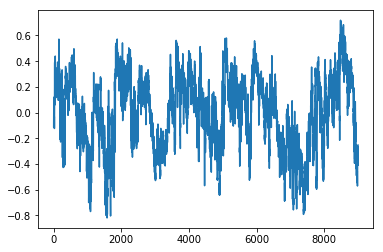

In [145]:
plt.plot(yw)

In [146]:

# Ogive

n = len(Csdxy)
ogive = np.zeros(n)
ogive[0]=(Csdxy*df)[0]
for i in range(1,n):
    k=n-1-i
    ogive[k]=ogive[k+1]+(Csdxy*df)[k]

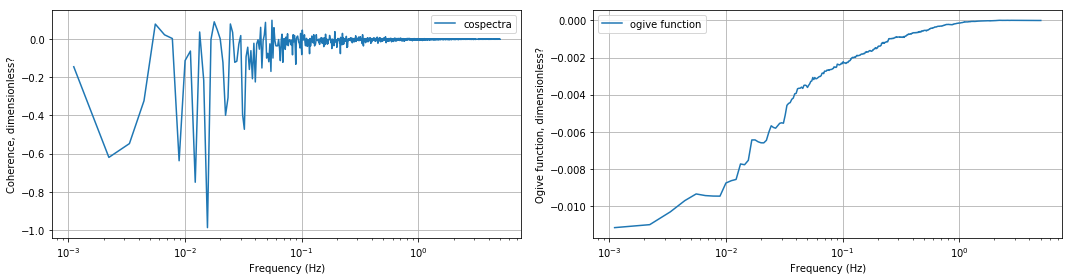

In [147]:


fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.grid(True)
ax1.semilogx(f,Csdxy,label='cospectra')
ax1.set_ylabel('Coherence, dimensionless?')
ax1.set_xlabel('Frequency (Hz)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(True)
ax2.semilogx(f,ogive,label='ogive function')
ax2.set_ylabel('Ogive function, dimensionless?')
ax2.set_xlabel('Frequency (Hz)')
ax2.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()

